In [7]:
import pandas as pd
import random
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

In [8]:

def clean_df(df):
    df.dropna(subset='Id', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'].astype(str).str.split().str[0])
    df['year'] = df['Date'].dt.year

    df['opener'] = df['Inngs'].astype(str).str.contains('GS', na=False)

    # game_id: sorted teams + date
    df['ateam'] = df[['Team', 'Opp']].min(axis=1)
    df['zteam'] = df[['Team', 'Opp']].max(axis=1)
    df['game_id'] = df['ateam'] + '_' + df['zteam']  + '_' + df['Date'].dt.strftime('%Y-%m-%d')

    df = df.sort_values(['Id', 'Date'])

    df['prev_game'] = df.groupby('Id')['Date'].shift(1)
    df['freshness'] = df['Date'] - df['prev_game']

    df['FIP'] = df['FIP'].apply(pd.to_numeric, errors='coerce')

    df.rename(columns={'Team': 'team',}, inplace=True)

    rid_ath = lambda x: x if x != "ATH" else "OAK"
    df['team'] = df['team'].apply(rid_ath)

    return df


def merge_with_meta(df, mdf):
    return df.merge(mdf, on=['team', 'year'])


def assemble_game_df(df, post_season=False):
    game_cols = ["game_id", "1_opener_fip", "1_opener_freshness", "1_others_fip", "1_others_freshness", "1_woba", "1_ooa", "1_home", "1_team", "1_is_wildcard", "2_opener_fip", "2_opener_freshness", "2_others_fip", "2_others_freshness", "2_woba", "w_ooa", "2_team", "2_is_wildcard", "is_playoff", "result"]
    game_rows = []

    label_map = {'W': 1,
                'L': 0,
                'T': 2}

    for game_id, game_group in df.groupby('game_id'):
        teams_data = []
        for team, team_group in game_group.groupby('team'):
            opener_df = team_group[team_group['opener']]
            others_df = team_group[~team_group['opener']]

            if opener_df.empty or others_df.empty:
                break 

            opener_fip = opener_df['FIP'].mean()
            opener_fresh = opener_df['freshness'].mean()

            # We really want top 3 or something here, should switch later
            # Also, we are looking not at the bench here but the other pitchers in the game. Not what we want.
            others_fip = others_df['FIP'].mean()
            others_fresh = others_df['freshness'].mean()

            team_name = team if team != "ATH" else "OAK"

            team_data = {
                "opener_fip": opener_fip,
                "opener_freshness": opener_fresh.total_seconds() / 3600,
                "others_fip": others_fip,
                "others_freshness": others_fresh.total_seconds() / 3600,
                "home": 1 if team_group.iloc[0]['Home'] == '@' else 0,
                "team": team_name,
                "result": label_map[team_group.iloc[0]['Result'][0]],
                "woba": team_group.iloc[0]['woba'],
                "ooa": team_group.iloc[0]['outs_above_average'],
                "is_wildcard": team_group.iloc[0]['is_wildcard'] if post_season else 0
            }
            teams_data.append(team_data)

        if len(teams_data) != 2:
            continue

        random.shuffle(teams_data)
        team1, team2 = teams_data

        is_playoff = 1 if post_season else 0

        game_data = [
        game_id,
        team1["opener_fip"], team1["opener_freshness"],
        team1["others_fip"], team1["others_freshness"],
        team1["woba"],       team1["ooa"],
        team1["home"],       team1["team"],
        team1["is_wildcard"],
        team2["opener_fip"], team2["opener_freshness"],
        team2["others_fip"], team2["others_freshness"],
        team2["woba"],       team2["ooa"],
        team2["team"],
        team2["is_wildcard"], 
        is_playoff,
        team1["result"]
        ]

        game_rows.append(dict(zip(game_cols, game_data)))

    games_df = pd.DataFrame(game_rows)

    return games_df

def get_game_df(df, mdf, post_season=False):
    cleaned = clean_df(df)
    merged = merge_with_meta(cleaned, mdf=mdf)
    games_df = assemble_game_df(merged, post_season=post_season)

    return games_df

In [9]:
psdf = pd.read_csv('data/ps_pitcher_logs.csv')
psdf.dropna(subset=['Gcar'], inplace=True)

dfs = []
for year in range(14, 26):
    if year == 24:
        continue
    file_path = f"data/pitcher_log_20{year}.csv"
    year_df = pd.read_csv(file_path, parse_dates=['Date'])
    year_df = year_df[~year_df['Gcar'].isna()]
    dfs.append(year_df)
rsdf = pd.concat(dfs, ignore_index=True)

team_map = {
    'Angels': 'LAA',
    'Astros': 'HOU',
    'Athletics': 'OAK',
    'Blue Jays': 'TOR',
    'Braves': 'ATL',
    'Brewers': 'MIL',
    'Cardinals': 'STL',
    'Cubs': 'CHC',
    'D-backs': 'ARI',
    'Dodgers': 'LAD',
    'Giants': 'SFG',
    'Guardians': 'CLE',
    'Mariners': 'SEA',
    'Marlins': 'MIA',
    'Mets': 'NYM',
    'Nationals': 'WSN',
    'Orioles': 'BAL',
    'Padres': 'SDP',
    'Phillies': 'PHI',
    'Pirates': 'PIT',
    'Rangers': 'TEX',
    'Rays': 'TBR',
    'Red Sox': 'BOS',
    'Reds': 'CIN',
    'Rockies': 'COL',
    'Royals': 'KCR',
    'Tigers': 'DET',
    'Twins': 'MIN',
    'White Sox': 'CHW',
    'Yankees': 'NYY'
}
switcher = lambda x: team_map[x]

metadf = pd.read_csv('data/cleaned_team_data.csv')
metadf = metadf[['team', 'year', 'outs_above_average', 'woba', 'is_wildcard']]
metadf['team'] = metadf['team'].apply(switcher)

In [10]:
ps_games_df = get_game_df(psdf, metadf, post_season=True)

rs_games_df = get_game_df(rsdf, metadf)

games_df = pd.concat([ps_games_df, rs_games_df])

In [11]:
games_df.to_csv('data/GAMES.csv', index=False)

In [12]:
from sklearn.model_selection import train_test_split

X, y = games_df.drop(columns=['game_id', '1_team', '2_team', 'result']), games_df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

CM = confusion_matrix(y_test, pred)
CR = classification_report(y_test, pred)
print(CM)
print(CR)

[[1797  710]
 [ 802 1637]]
              precision    recall  f1-score   support

           0       0.69      0.72      0.70      2507
           1       0.70      0.67      0.68      2439

    accuracy                           0.69      4946
   macro avg       0.69      0.69      0.69      4946
weighted avg       0.69      0.69      0.69      4946



In [19]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2']
}

rf_base = RandomForestClassifier(random_state=42)

rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

rf.fit(X_train, y_train)
pred = rf.predict(X_test)

# Create confusion matrix, print, along with the best params and the best score
CM = confusion_matrix(y_test, pred)
print("Best parameters:", rf.best_params_)
print("Best score:", rf.best_score_)
print("Confusion matrix:", CM)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


KeyboardInterrupt: 

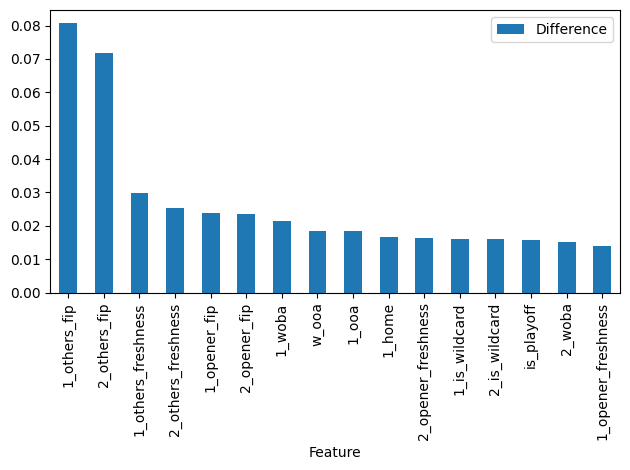

In [21]:
def scramble_feature_vals(feature_vals):
    return np.random.permutation(feature_vals.values)

def compute_feature_importance(feature_name, og_f1, X_test=X_test, y_test=y_test, model=rf):
    X_test_copy = X_test.copy()
    X_test_copy[feature_name] = scramble_feature_vals(X_test_copy[feature_name])

    pred = model.predict(X_test_copy)
    new_f1 = f1_score(y_test, pred)
    diff = og_f1 - new_f1

    return new_f1, diff

n = len(X_test.columns)
table = {
    'Feature': X_test.columns,
    'Original F1': [0.7] * n,
    'New F1': [],
    'Difference': []
}

for col in X_test.columns:
    new_f1, diff = compute_feature_importance(col, 0.7)
    table['New F1'].append(new_f1)
    table['Difference'].append(diff)

importance = pd.DataFrame(table)

# Sort by Difference (descending)
importance = importance.sort_values(by="Difference", ascending=False)

importance.plot.bar(x='Feature', y='Difference', legend=True)

plt.tight_layout()
plt.show()


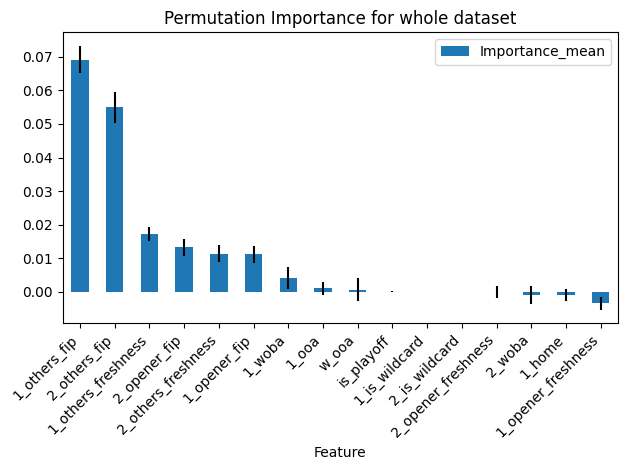

In [22]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test,
    n_repeats=10,        # more repeats = smoother estimates
    scoring='f1',        # or 'f1_macro', 'roc_auc', etc.
    random_state=42
)

importances = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance_mean": result.importances_mean,
    "Importance_std": result.importances_std
}).sort_values("Importance_mean", ascending=False)

importances.plot.bar(x="Feature", y="Importance_mean", yerr="Importance_std")
plt.title("Permutation Importance for whole dataset")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


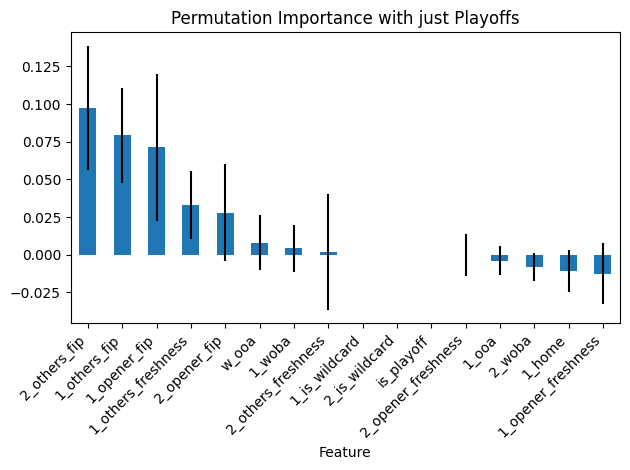

In [23]:
mask = X_test['is_playoff'] == 1
X_playoffs, y_playoffs = X_test[mask], y_test[mask]

result = permutation_importance(
    rf,
    X_playoffs,
    y_playoffs,
    n_repeats=10,
    scoring='f1',
    random_state=42,
)

importances = pd.DataFrame({
    "Feature": X_playoffs.columns,
    "Importance_mean": result.importances_mean,
    "Importance_std": result.importances_std
}).sort_values("Importance_mean", ascending=False)

importances.plot.bar(
    x="Feature",
    y="Importance_mean",
    yerr="Importance_std",
    legend=False
)

plt.title("Permutation Importance with just Playoffs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

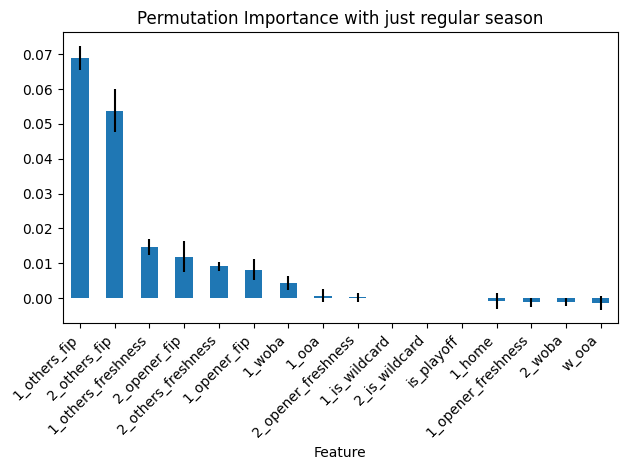

In [25]:
mask = X_test['is_playoff'] == 0
X_rs, y_rs = X_test[mask], y_test[mask]

result = permutation_importance(
    rf,
    X_rs,
    y_rs,
    n_repeats=10,
    scoring='f1',
    random_state=42,
)

importances = pd.DataFrame({
    "Feature": X_rs.columns,
    "Importance_mean": result.importances_mean,
    "Importance_std": result.importances_std
}).sort_values("Importance_mean", ascending=False)

importances.plot.bar(
    x="Feature",
    y="Importance_mean",
    yerr="Importance_std",
    legend=False
)

plt.title("Permutation Importance with just regular season")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

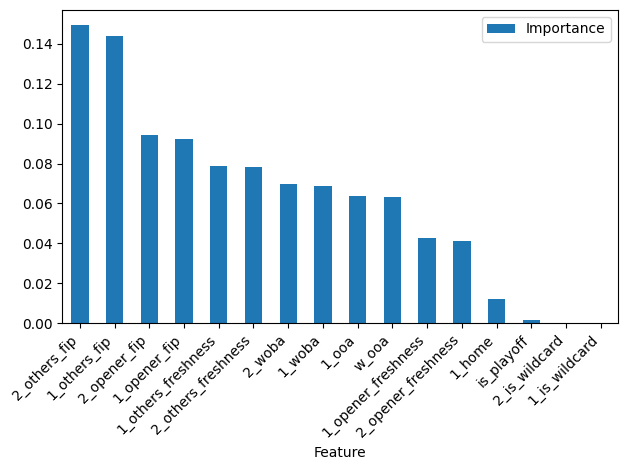

In [ ]:
impurity_imp = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

impurity_imp.plot.bar(x="Feature", y="Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [27]:
games_df.columns

Index(['game_id', '1_opener_fip', '1_opener_freshness', '1_others_fip',
       '1_others_freshness', '1_woba', '1_ooa', '1_home', '1_team',
       '1_is_wildcard', '2_opener_fip', '2_opener_freshness', '2_others_fip',
       '2_others_freshness', '2_woba', 'w_ooa', '2_team', '2_is_wildcard',
       'is_playoff', 'result'],
      dtype='object')

In [28]:
len(games_df[games_df['is_playoff'] == 1])

317

# TODO
- Try feature importance but with ooba(?) and whole tree, and only for playoff games or only for wildcard games. I wonder if its influence is diluted by the huge tree
- Try and move FIP so it doesn't contaminate the score as much--maybe move it up one to the players next game so it's like "Current FIP"